# Trend-following breakout strategy

This notebook displays the performance of trend-following strategies across major asset classes. The difference here compared to Moskowitz et al (2012) is that the trend signal is computed by the so-called "breakout" methodology. In this analysis, a simple breakout rule is tested where a long position is entered when the current price is above the local max (lookback = 1 year). The long position is maintained until the price goes below trailing minimum after which the position is flipped to short. Similar to Moskowitz et al (2012) the resulting signal is binary where there is no neutral position.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import BacktestEngine, signal, processing
from vivace.backtest.analytics import rebase
from vivace.backtest.contract import all_futures_moskowitz2012
from vivace.backtest.enums import Strategy, Weighting
from vivace.backtest.stats import Performance, PerfStats

# Data

The same trading universe as `trend_following_moskowitz2012.ipynb` is used covering 50 futures contracts.

In [2]:
all_futures_moskowitz2012['name'].values

array(['Aluminium', 'Brent Crude Oil', 'Live Cattle', 'Cocoa', 'Coffee',
       'Copper', 'Corn', 'Cotton', 'WTI Crude Oil', 'Gas Oil', 'Gold',
       'Heating Oil', 'Lean Hog', 'Natural Gas', 'Nickel', 'Platinum',
       'Silver', 'Soybean', 'Soybean Meal', 'Soybean Oil', 'Sugar',
       'Gasoline', 'Wheat', 'Zinc', 'Australian Dollar', 'British Pound',
       'Euro', 'Canadian Dollar', 'Japanese Yen', 'SPI 200', 'DAX',
       'IBEX 35', 'CAC 40', 'Topix', 'AEX', 'FTSE 100', 'S&P 500',
       'Australia 3-year Treasury', 'Australia 10-year Treasury',
       'Germany Schatz', 'Germany Bobl', 'Germany Bund', 'Germany Buxl',
       'Canada 10-year Treasury', 'JGB', 'Gilt', 'US 2-year Treasury',
       'US 5-year Treasury', 'US 10-year Treasury', 'US Treasury Bond'],
      dtype=object)

In [3]:
len(all_futures_moskowitz2012)

50

# Performance

## Breakout strategy

The above instruments are combined with a equal-risk (realised volatility) weighting methodology. 

In [4]:
engine_breakout = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_moskowitz2012.index,
    signal=signal.ParallelSignal([
        signal.VolatilityScale(agg_method='ewm', com=60, ann_factor=261, 
                               target_volatility=0.4, signal_cap=0.95,
                               post_process=processing.AsFreq(freq='m', method='pad')),
        signal.BreakoutLocalExtreme()
    ], weighting='product'),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine_breakout.run()

In [5]:
portfolio_breakout = (engine_breakout.calculate_equity_curve(calculate_net=False, rebalance_freq='m')
                      .rename('Trend-following breakout portfolio'))

## TSMOM

The same backtest configuration as `trend_following_moskowitz2012.ipynb` is analyses as a benchmark.

In [6]:
engine_tsmom = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_moskowitz2012.index,
    signal=signal.ParallelSignal([
        signal.VolatilityScale(agg_method='ewm', com=60, ann_factor=261, 
                               target_volatility=0.4, signal_cap=0.95,
                               post_process=processing.AsFreq(freq='m', method='pad')),
        signal.TSMOMMoskowitz2012(post_process=processing.AsFreq(freq='m', method='pad'))
    ], weighting='product'),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine_tsmom.run()

In [7]:
portfolio_tsmom = (engine_tsmom.calculate_equity_curve(calculate_net=False, rebalance_freq='m')
                   .rename('Trend-following portfolio (Moskowitz 2012)'))

## Portfolio

As mentioned in Chevallier and Ielpo (2014), the breakout strategy seem to capture the same premium as the TSMOM implementation. Performance look broadly similar to each other.

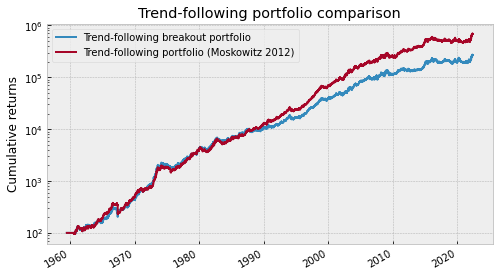

In [8]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_comparison = pd.concat((
    portfolio_breakout,
    portfolio_tsmom
), axis=1)

portfolio_comparison.plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio comparison')
ax.set_ylabel('Cumulative returns');

In [9]:
portfolio_comparison.pipe(Performance).summary()

,Trend-following breakout portfolio,Trend-following portfolio (Moskowitz 2012)
CAGR,0.122646,0.137236
Annualised vol,0.121741,0.123448
Sharpe ratio,1.007435,1.111696
Max drawdown,0.355000,0.397622
Calmar ratio,0.345483,0.345143
Skewness,-0.188925,-0.332754
Kurtosis,7.564378,7.492923
Worst return,-0.081832,-0.085340
Worst 1d return,-0.081832,-0.085340
Worst 1w return,-0.155506,-0.150663


## Breakdown by futures contract

Most of the contracts contributed positively when the trend-following signal is applied.

In [10]:
instrument_breakout = engine_breakout.get_return_by_instrument(calculate_net=False).cumsum()
instrument_tsmom = engine_tsmom.get_return_by_instrument(calculate_net=False).cumsum()

In [11]:
sharpe_breakout = (instrument_breakout.pipe(Performance, return_type='diff').sharpe().T
                   .join(all_futures_moskowitz2012)
                   .sort_values(['asset_class', 'name'])
                   .set_index('name')
                   [PerfStats.SHARPE.value]
                   .rename('Breakout'))
sharpe_tsmom = (instrument_tsmom.pipe(Performance, return_type='diff').sharpe().T
                .join(all_futures_moskowitz2012)
                .sort_values(['asset_class', 'name'])
                .set_index('name')
                [PerfStats.SHARPE.value]
                .rename('TSMOM'))

From the performance breakdown below, it's hard to judge which is sperior or not. 

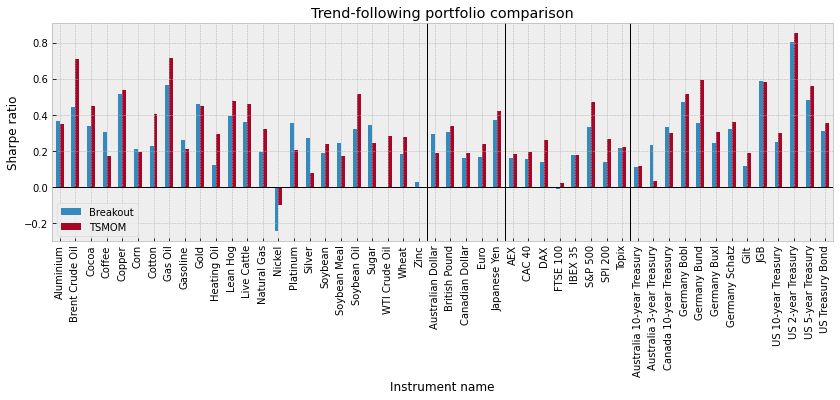

In [12]:
fig, ax = plt.subplots(figsize=(14, 4))
pd.concat((sharpe_breakout, sharpe_tsmom), axis=1).plot(kind='bar', ax=ax)

ax.set_title('Trend-following portfolio comparison')
ax.set_ylabel(PerfStats.SHARPE.value);
ax.set_xlabel('Instrument name')
ax.axhline(0, lw=1, color='black');
ax.axvline(23.5, lw=1, color='black');
ax.axvline(28.5, lw=1, color='black');
ax.axvline(36.5, lw=1, color='black');

## Post puiblication

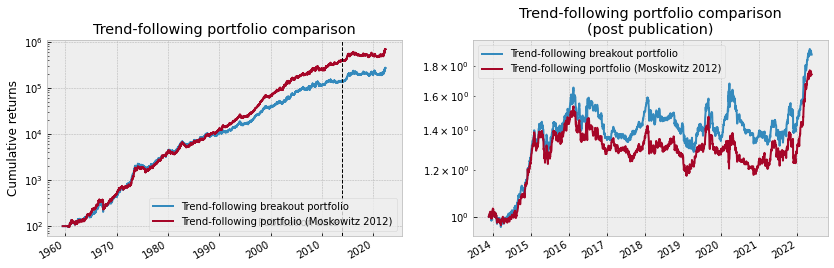

In [13]:
publication_date = datetime(2013, 11, 18)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
portfolio_comparison.plot(ax=ax[0], logy=True);
ax[0].set_title('Trend-following portfolio comparison')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

portfolio_comparison.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Trend-following portfolio comparison\n(post publication)');

## Recent performance

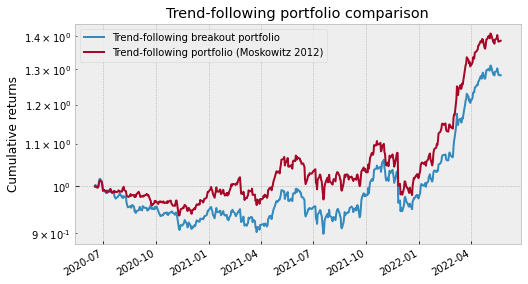

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_comparison.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio comparison')
ax.set_ylabel('Cumulative returns');

# Reference

- Moskowitz, T.J., Ooi, Y.H. and Pedersen, L.H., 2012. Time series momentum. Journal of financial economics, 104(2), pp.228-250.
- Chevallier, J. and Ielpo, F., 2014. “Time series momentum” in commodity markets. Managerial Finance.

In [15]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 24-May-2022 07:31
